## Commodity Arbitrage


In [2]:
import math
print("Hello")
print(math.sqrt(9))

Hello
3.0


### 1. Setup
Load spot prices, interest rates, futures prices

#### Pulling daily spot prices from EIA

In [3]:
import requests
import pandas as pd

def fetch_henry_hub_prices(api_key: str) -> pd.DataFrame:
    url = "https://api.eia.gov/v2/natural-gas/pri/fut/data/"
    params = {
        "api_key": api_key,
        "frequency": "daily",
        "data[0]": "value",
        "facets[series][]": "RNGWHHD",
        "sort[0][column]": "period",
        "sort[0][direction]": "desc",
        "offset": 0,
        "length": 5000
    }

    response = requests.get(url, params=params)
    
    try:
        data = response.json()
    except ValueError:
        raise ValueError("❌ Could not parse JSON from EIA response.")

    if "response" not in data or "data" not in data["response"]:
        print("⚠️ Error in API response:")
        print(data)
        raise KeyError("Missing 'response' or 'data' in the EIA response.")

    records = data["response"]["data"]
    df = pd.DataFrame(records)
    df["period"] = pd.to_datetime(df["period"])
    df.rename(columns={"value": "Price", "period": "Date"}, inplace=True)
    return df.sort_values("Date").reset_index(drop=True)

# Example usage:
api_key = "enWWFz4uSsndQKaiHTxoNtXw22Ypl9HFMEo6eHak"  # Replace with your actual API key

try:
    df = fetch_henry_hub_prices(api_key)
    print(df.head())
except Exception as e:
    print(f"❌ Error: {e}")

        Date duoarea area-name product product-name process process-name  \
0 2005-05-31     RGC        NA    EPG0  Natural Gas     PS0   Spot Price   
1 2005-06-01     RGC        NA    EPG0  Natural Gas     PS0   Spot Price   
2 2005-06-02     RGC        NA    EPG0  Natural Gas     PS0   Spot Price   
3 2005-06-03     RGC        NA    EPG0  Natural Gas     PS0   Spot Price   
4 2005-06-06     RGC        NA    EPG0  Natural Gas     PS0   Spot Price   

    series                                 series-description Price    units  
0  RNGWHHD  Henry Hub Natural Gas Spot Price (Dollars per ...  6.31  $/MMBTU  
1  RNGWHHD  Henry Hub Natural Gas Spot Price (Dollars per ...  6.36  $/MMBTU  
2  RNGWHHD  Henry Hub Natural Gas Spot Price (Dollars per ...  6.63  $/MMBTU  
3  RNGWHHD  Henry Hub Natural Gas Spot Price (Dollars per ...  6.65  $/MMBTU  
4  RNGWHHD  Henry Hub Natural Gas Spot Price (Dollars per ...  7.05  $/MMBTU  


### 2. Clean up data

In [4]:
df_clean = df[["Date", "Price"]].copy()
df_clean["Price"] = pd.to_numeric(df_clean["Price"], errors="coerce")
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean = df_clean.sort_values("Date").reset_index(drop=True)

print(df_clean.head())

        Date  Price
0 2005-05-31   6.31
1 2005-06-01   6.36
2 2005-06-02   6.63
3 2005-06-03   6.65
4 2005-06-06   7.05


#### 3. Chart

Date range: 2005-05-31 → 2025-03-31


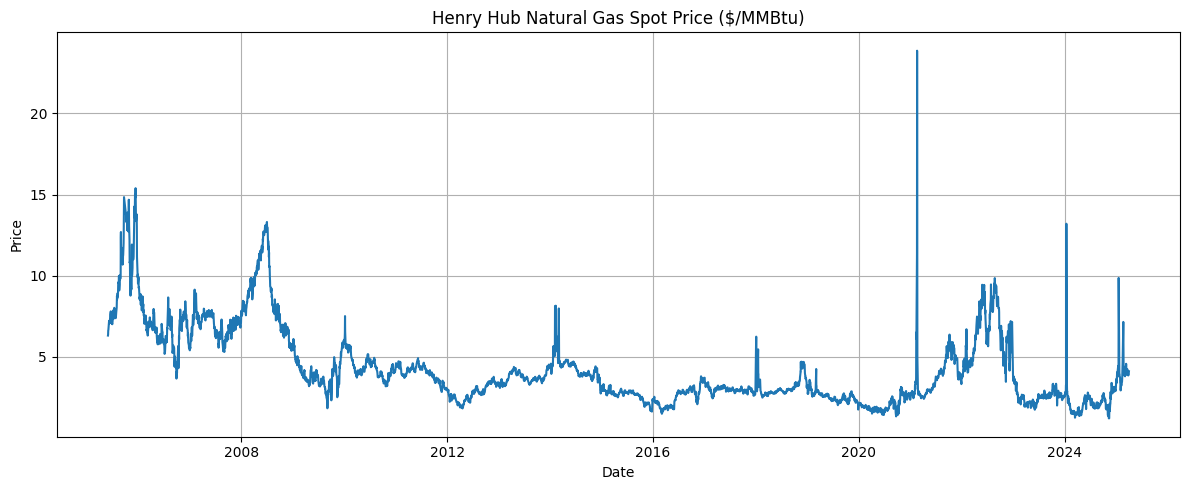

In [5]:
import matplotlib.pyplot as plt
print(f"Date range: {df_clean['Date'].min().date()} → {df_clean['Date'].max().date()}")

plt.figure(figsize=(12, 5))
plt.plot(df_clean["Date"], df_clean["Price"])
plt.title("Henry Hub Natural Gas Spot Price ($/MMBtu)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4.Import futures prices from Yahoo finance and merge dataframes

In [7]:
import yfinance as yf
import pandas as pd

# Download futures data
raw_futures = yf.download("NG=F", start="2005-01-01", end="2025-01-01", interval="1d")

# Extract and flatten 'Close' column from MultiIndex
futures_close = raw_futures.loc[:, ("Close", "NG=F")].reset_index()
futures_close.columns = ["Date", "Futures_Price"]

# Convert to proper datetime and drop any missing values
futures_close["Date"] = pd.to_datetime(futures_close["Date"])
futures_close.dropna(inplace=True)

# Now merge it with df_clean
combined_df = pd.merge(df_clean, futures_close, on="Date", how="inner")

# Calculate basis
combined_df["Basis"] = combined_df["Futures_Price"] - combined_df["Price"]

print(combined_df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

        Date  Price  Futures_Price  Basis
0 2005-05-31   6.31          6.379  0.069
1 2005-06-01   6.36          6.789  0.429
2 2005-06-02   6.63          6.819  0.189
3 2005-06-03   6.65          6.880  0.230
4 2005-06-06   7.05          7.122  0.072


#### 5. Assumption

In [8]:
import numpy as np

# Assumptions
annual_r = 0.05  # 5% interest rate
annual_u = 0.02  # 2% storage cost
annual_y = 0.01  # 1% convenience yield
T = 1/12         # 1-month time to maturity

#### 6. Cost-of-carry futures price

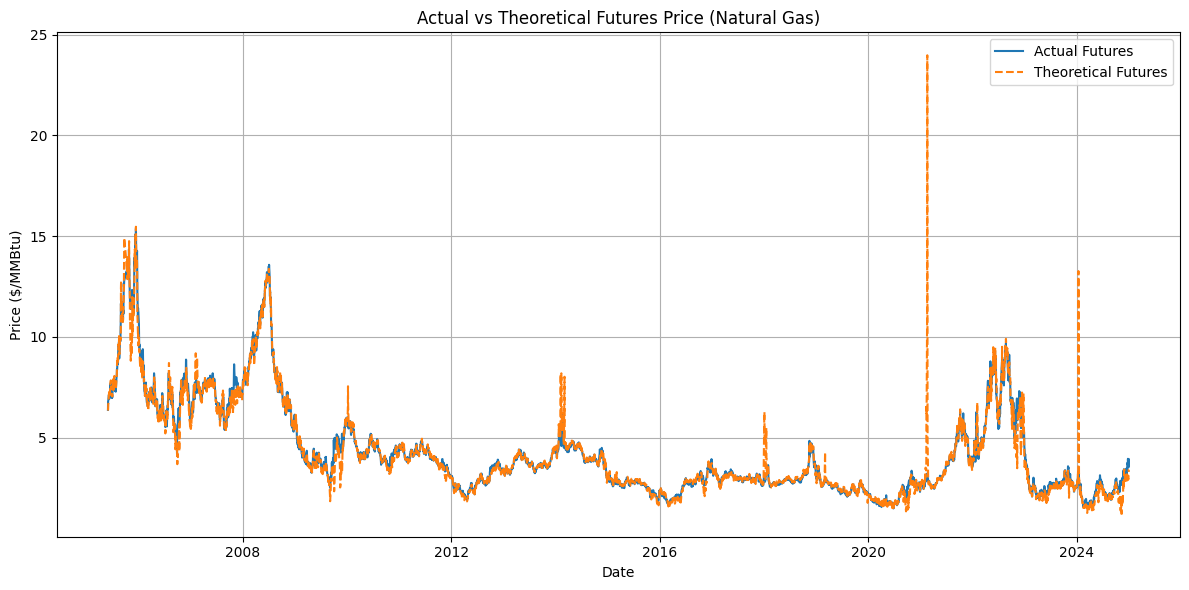

In [9]:
import matplotlib.pyplot as plt

combined_df["F_theoretical"] = combined_df["Price"] * np.exp((annual_r + annual_u - annual_y) * T)

plt.figure(figsize=(12, 6))
plt.plot(combined_df["Date"], combined_df["Futures_Price"], label="Actual Futures")
plt.plot(combined_df["Date"], combined_df["F_theoretical"], label="Theoretical Futures", linestyle="--")
plt.title("Actual vs Theoretical Futures Price (Natural Gas)")
plt.xlabel("Date")
plt.ylabel("Price ($/MMBtu)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 7. Calculate divergence

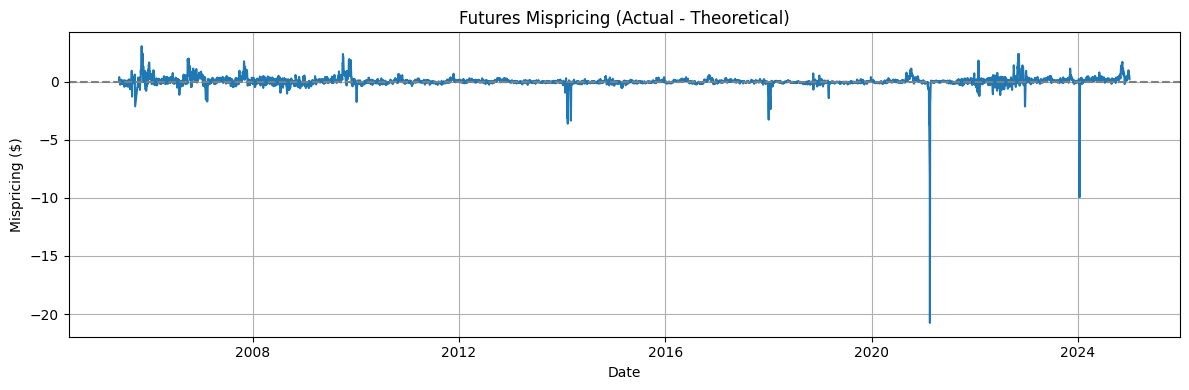

In [10]:
combined_df["Mispricing"] = combined_df["Futures_Price"] - combined_df["F_theoretical"]

plt.figure(figsize=(12, 4))
plt.plot(combined_df["Date"], combined_df["Mispricing"])
plt.axhline(0, color="gray", linestyle="--")
plt.title("Futures Mispricing (Actual - Theoretical)")
plt.ylabel("Mispricing ($)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 8. Calculate historical arbitrage opportunities

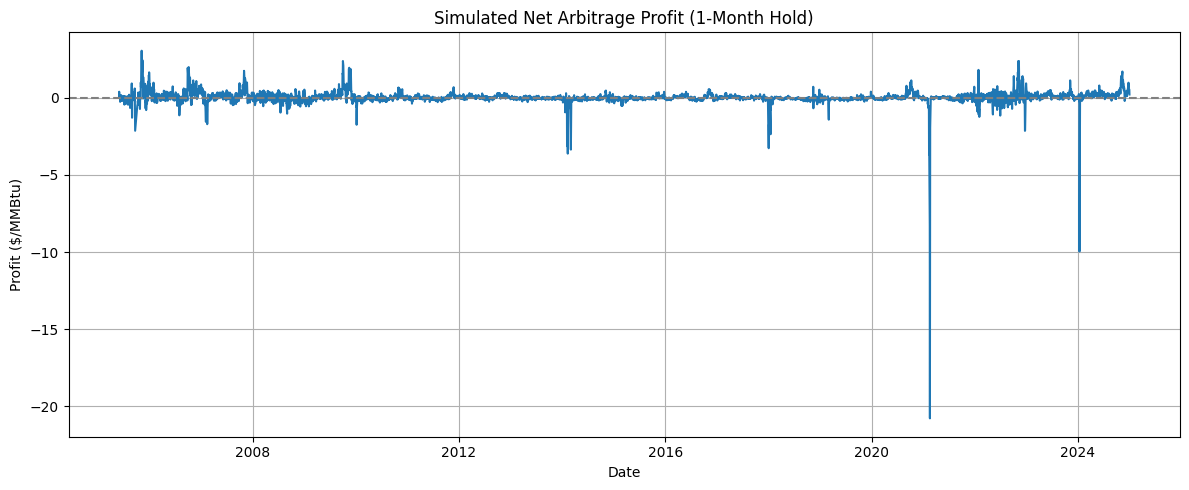

In [11]:
# Assumptions
# Annual rates
annual_r = 0.05  # 5% interest (financing cost)
annual_u = 0.02  # 2% storage cost
T = 1/12         # 1-month arbitrage horizon

# Convert annual to monthly
r_monthly = annual_r * T
u_monthly = annual_u * T

# Gross arbitrage return
combined_df["Gross_Arb_Profit"] = combined_df["Futures_Price"] - combined_df["Price"]

# Total cost of carry
combined_df["Cost_of_Carry"] = combined_df["Price"] * (r_monthly + u_monthly)

# Net arbitrage profit
combined_df["Net_Arb_Profit"] = combined_df["Gross_Arb_Profit"] - combined_df["Cost_of_Carry"]

plt.figure(figsize=(12, 5))
plt.plot(combined_df["Date"], combined_df["Net_Arb_Profit"])
plt.axhline(0, color='gray', linestyle='--')
plt.title("Simulated Net Arbitrage Profit (1-Month Hold)")
plt.xlabel("Date")
plt.ylabel("Profit ($/MMBtu)")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 9. Prepare for logistic regression to predict when arbitrage opportunity > $0.10
(Because this is publicly available: DON'T use this as financial advise. I have made several assumptions in these model that are not necessarily accurate.)

In [12]:
# Target: 1 if arbitrage > $0.10, else 0
combined_df["Arb_Opportunity"] = (combined_df["Net_Arb_Profit"] > 0.10).astype(int)

# Lagged returns (momentum)
combined_df["Spot_Return_1d"] = combined_df["Price"].pct_change()
combined_df["Fut_Return_1d"] = combined_df["Futures_Price"].pct_change()

# Volatility (rolling std)
combined_df["Spot_Vol_5d"] = combined_df["Price"].rolling(window=5).std()
combined_df["Basis"] = combined_df["Futures_Price"] - combined_df["Price"]

# Time-based feature
combined_df["Month"] = combined_df["Date"].dt.month

# Drop rows with NaNs (from rolling/lag features)
model_df = combined_df.dropna().copy()

# Define X and y
features = [
    "Price",           # Spot price
    "Spot_Return_1d",  # 1-day momentum
    "Spot_Vol_5d",     # Volatility
    "Month"            # Seasonal pattern
]
X = model_df[features]
y = model_df["Arb_Opportunity"]
print(X.head())

   Price  Spot_Return_1d  Spot_Vol_5d  Month
4   7.05        0.060150     0.294788      6
5   7.13        0.011348     0.320125      6
6   7.22        0.012623     0.276912      6
7   7.05       -0.023546     0.218403      6
8   7.09        0.005674     0.070852      6


#### 10. Logistic regression
Learning moment: I included basis in the list of features when I first ran it, and my model 'predicted' 99% of arbitrage opportunities. This was an obvious mistake. 

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.96      0.73       573
           1       0.37      0.03      0.06       407

    accuracy                           0.58       980
   macro avg       0.48      0.50      0.39       980
weighted avg       0.50      0.58      0.45       980



#### 11. Random forest classifier

In [14]:
features = ["Price", "Spot_Return_1d", "Spot_Vol_5d", "Month"]

X = model_df[features]
y = model_df["Arb_Opportunity"]

In [15]:
from sklearn.model_selection import train_test_split

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       573
           1       0.78      0.59      0.67       407

    accuracy                           0.76       980
   macro avg       0.77      0.74      0.74       980
weighted avg       0.76      0.76      0.75       980



#### 12. Feature importance

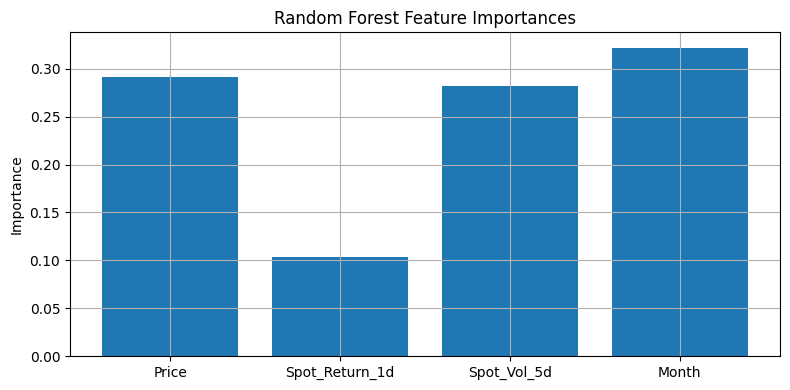

In [17]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 4))
plt.bar(feature_names, importances)
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 13. Adding lagged 5-d average to Random Forest model

In [18]:
combined_df["Lagged_Basis_5d"] = combined_df["Basis"].rolling(window=5).mean().shift(1)

model_df = combined_df.dropna().copy()

features = ["Price", "Spot_Return_1d", "Spot_Vol_5d", "Month", "Lagged_Basis_5d"]

X = model_df[features]
y = model_df["Arb_Opportunity"]

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Time-based split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train with added feature
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       573
           1       0.78      0.59      0.67       407

    accuracy                           0.76       980
   macro avg       0.77      0.74      0.74       980
weighted avg       0.76      0.76      0.75       980



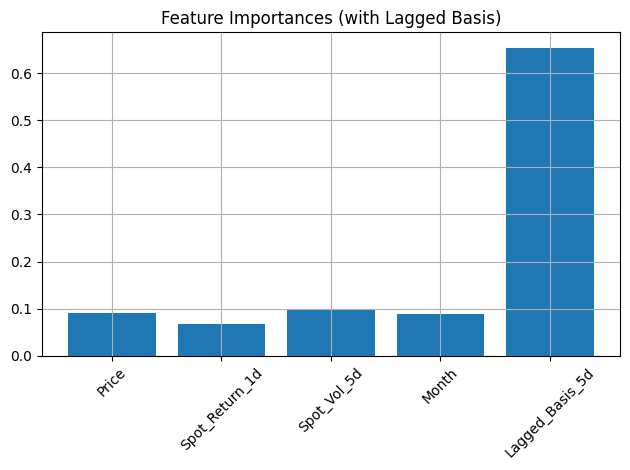

In [22]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
plt.bar(X.columns, importances)
plt.title("Feature Importances (with Lagged Basis)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

14. Suspicion: Are our results too good? 

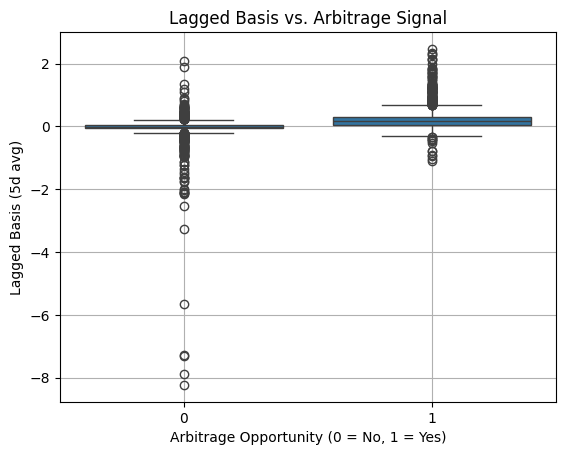

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=model_df["Arb_Opportunity"], y=model_df["Lagged_Basis_5d"])
plt.title("Lagged Basis vs. Arbitrage Signal")
plt.xlabel("Arbitrage Opportunity (0 = No, 1 = Yes)")
plt.ylabel("Lagged Basis (5d avg)")
plt.grid(True)
plt.show()

15. Backtesting

In [26]:
#Predictions
model_df = model_df.iloc[-len(X_test):].copy()  # align with test set
model_df["Predicted"] = y_pred
model_df["Correct"] = (model_df["Predicted"] == model_df["Arb_Opportunity"]).astype(int)

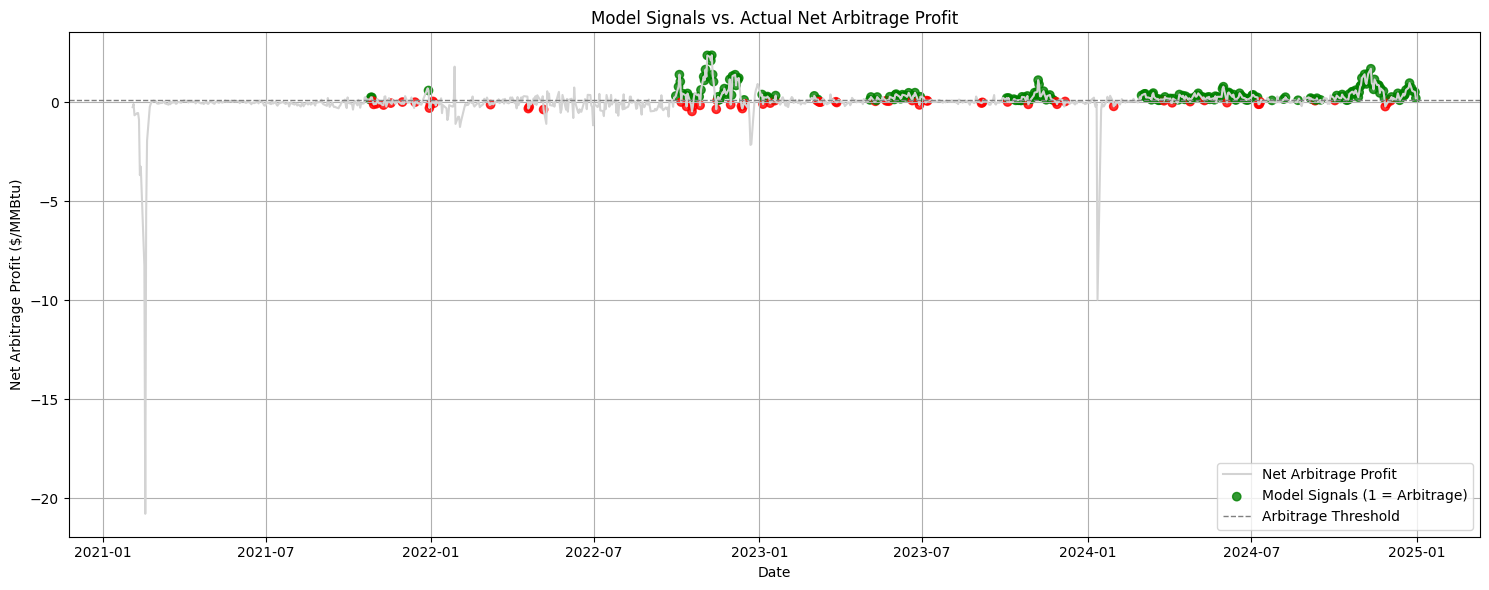

In [28]:
#Signals over time
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(model_df["Date"], model_df["Net_Arb_Profit"], label="Net Arbitrage Profit", color='lightgray')

# Plot correct predictions
plt.scatter(
    model_df[model_df["Predicted"] == 1]["Date"],
    model_df[model_df["Predicted"] == 1]["Net_Arb_Profit"],
    c=model_df[model_df["Predicted"] == 1]["Correct"].map({1: 'green', 0: 'red'}),
    label="Model Signals (1 = Arbitrage)",
    marker='o',
    alpha=0.8
)

plt.axhline(0.1, color="gray", linestyle="--", linewidth=1, label="Arbitrage Threshold")
plt.title("Model Signals vs. Actual Net Arbitrage Profit")
plt.ylabel("Net Arbitrage Profit ($/MMBtu)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This is a sample project on arbitrage opportunities in the natural gas market (Henry Hub). I've provided two different models, linear regression and random forest classifier. Notable assumptions made (which means these models should not be trusted too heavily):
1. Interest rates
2. Carry capacity
3. 

In [29]:
import joblib
joblib.dump(rf, "random_forest_model.pkl")

['random_forest_model.pkl']

In [3]:
model_df.to_csv("clean_features.csv", index=False)


NameError: name 'model_df' is not defined

In [2]:
model_df["Date"].min(), model_df["Date"].max()


NameError: name 'model_df' is not defined